# In-context data-driven closed loop control of states

Ayush Pandey

Date: March 21, 2025


## System examples
In this notebook, I will show a DMD-control driven predictive control with different number of context examples. The system we consider is: $x(k+1) = Ax(k) + Bu(k)$, where $k$ is the discrete system time step. 

## Data-driven in-context predictions
Assume that we collect tuples $(X, X')$, where $X$ is stacked observations until time $k-1$ and X' includes the last observation until time $k$. With these observations, our goal (in this example) is to predict the future states $x$ by learning from the given data and implicitly applying the same control law $u$. We do not know the system matrices $A$, $B$, and have no information about the control signals $u$. So, the prediction task is:

For each context length $l \in [1, 2, ..., L]$ at a given time point $s > L$, we predict:

$(x_{s-l}, x_{s-l+1}, ..., x_s) \rightarrow \hat{x}_{s+1}$.

Then, we forward predict for this context length $l$ until time $T > s$:
 
$(x_{s-l}, x_{s-l+1}, ..., x_s, \hat{x}_{s+1}) \rightarrow \hat{x}_{s+2}$

...

...

...

$(x_{s-l}, x_{s-l+1}, ..., x_s, \hat{x}_{s+1}, ...\hat{x}_{T-1}) \rightarrow \hat{x}_{T}$

Repeating this for all values of $l$, we study the performance of DMD control in in-context prediction accuracy with number of context examples. For this example, we consider an unstable system and we assume that there is an unknown control input applied to get the prediction at each next step that stabilizes the system. We do not use the knowledge of $u$ when predicting the next states. 

In [2]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
plt.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 
                     'xtick.major.size': 6, 'xtick.major.width': 2, 
                     'ytick.major.size': 6, 'ytick.major.width': 2}
                    )
# same updates global for plotly: font size, xtick and ytick size, and axes lw
px.defaults.template = "plotly_dark" 
import control as ct

### Linear scalar unstable system (with stabilizing control)
We use a linearized system dynamics to generate the data to train the DMD-control method. For this, we define an unstable system 

$x' = Ax + Bu$, and 

$y = Cx$ 

with 

$A = \begin{bmatrix}2 & 0.5 \\ 0 & 0.75 \end{bmatrix}$

with control over the unstable state through the $B$ matrix:

$B = \begin{bmatrix} 1 \\ 0 \end{bmatrix}$

and, setting identity $C$ matrix so that we can observe both states to record the available training data,

$C = \begin{bmatrix}1 & 0 \\ 0 & 1\end{bmatrix}$

We set an arbitrary initial condition $x_0 = \begin{bmatrix} 6 \\ 10 \end{bmatrix}$ and a stabilizing state-feedback control law $K = \begin{bmatrix} 0.75 & 0 \end{bmatrix}$.

Note that the DMD method cannot access the matrices $A, B, K$ or the control signals $u$. We will only use the data measurements in-context to control the system here as defined above. Start by defining and simulating the system to generate the data.

## Generate data

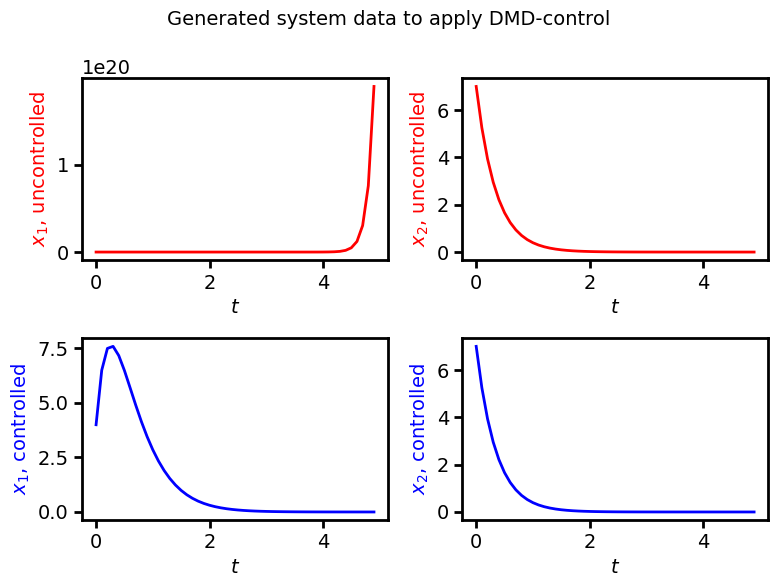

In [6]:
# DMD-control
A = np.array([[2.5, 0.5], [0, 0.75]])
B = np.array([[1], [0]])
C = np.array([[1, 0], [0, 1]])
D = 0
sys_ol = ct.ss(A, B, C, D, dt=0.1) # open loop
x0 = [4, 7]
t = np.arange(0, 5, 0.1)
t, y_gt_ol = ct.initial_response(sys_ol, t, x0) 
K = np.array([[1.75], [0]]).T # control law
sys_cl = ct.ss(A-B@K, [0,0], C, D, dt=0.1) # closed loop
t, y_gt_cl = ct.initial_response(sys_cl, t, x0)
fig, ax = plt.subplots(2,2, figsize=(8, 6))
ax[0,0].plot(t, y_gt_ol[0,], lw=2, c='r')
ax[0,1].plot(t, y_gt_ol[1,], lw=2, c='r')
ax[0,0].set_ylabel('$x_1$, uncontrolled', c='r')
ax[0,0].set_xlabel('$t$')
ax[0,1].set_xlabel('$t$')
ax[0,1].set_ylabel('$x_2$, uncontrolled', c='r')
ax[1,0].plot(t, y_gt_cl[0,], lw=2, c='b')
ax[1,1].plot(t, y_gt_cl[1,], lw=2, c='b')
ax[1,0].set_ylabel('$x_1$, controlled', c='b')
ax[1,0].set_xlabel('$t$')
ax[1,1].set_xlabel('$t$')
ax[1,1].set_ylabel('$x_2$, controlled', c='b')
fig.suptitle('Generated system data to apply DMD-control', fontsize=14)
plt.tight_layout()
plt.show()

In [10]:
# Create all data matrices (an example with l = 4 context length)
X = y_gt_cl[:, :4]
X_prime = y_gt_cl[:, 1:5]
print("X is:")
print(X)
print("X' is:")
print(X_prime)

X is:
[[4.       6.5      7.5      7.59375 ]
 [7.       5.25     3.9375   2.953125]]
X' is:
[[6.5        7.5        7.59375    7.171875  ]
 [5.25       3.9375     2.953125   2.21484375]]


Some plotting utility code below 

In [11]:
# Plot code
def plot_sys_response(figure_objects, t, y_gt, **kwargs):
    fig1, fig2 = figure_objects
    name = kwargs.get('name', 'x')
    color = kwargs.get('color', 'blue')
    # add scatter points on top of the lines with same color dots with black boundary within same trace
    fig1.add_trace(
        go.Scatter(
            x=t,
            y=y_gt[0,],
            mode="lines+markers",
            name=name,
            line=dict(color=color, width=2),
            marker=dict(
                color=color,
                line=dict(color="black", width=1),
                size=6
            )
        )
    )
    fig2.add_trace(
        go.Scatter(
            x=t,
            y=y_gt[1,],
            mode="lines+markers",
            name=name,
            line=dict(color=color, width=2),
            marker=dict(
                color=color,
                line=dict(color="black", width=1),
                size=6
            )
        )
    )
    return fig1, fig2

In [19]:
T = len(t)
points = np.linspace(0.5, 1.0, T)
color_list = px.colors.sample_colorscale(px.colors.sequential.GnBu, points)
M_icl = T//2 # set max number in-context length to be half of the total time points
M_icl = 10  # Use this to test fixed number of in-context length
m_p = T - M_icl # the size of prediction window

fig1 = go.Figure()
fig2 = go.Figure()
fig3 = go.Figure()
# The main function that iterative estimates the closed loop system to use to predict the state x:
 
def compute_dmd_control(X, X_prime):
    U, S, Vh = np.linalg.svd(X, full_matrices=False)
    S_inv = np.diag(1/S)
    A_approx_cl = (X_prime)@Vh.T@S_inv@U.T
    return A_approx_cl

mse_list = []
for i in range(M_icl):
    # context data X and X'
    X = y_gt_cl[:, M_icl-i-1:M_icl]
    X_prime = y_gt_cl[:, M_icl-i:M_icl+1]
    A_approx_cl = compute_dmd_control(X, X_prime)
    # forward prediction
    for j in range(m_p):
        # we set C = identity to observe all states 
        # in the simulation of this approximated system
        cl_sys = ct.ss(A_approx_cl, [0,0], np.eye(2), 0, dt=0.1)
        prediction_timepoints = np.array([cl_sys.dt]) # only one step ahead
        starting_x = X_prime[:,-1].reshape(-1,1)
        # get the predicted state
        t_sim, y_pred = ct.initial_response(cl_sys, prediction_timepoints, starting_x)
        # update X and X_prime
        X_prime = np.hstack((X_prime, y_pred[:,-1].reshape(-1,1)))
        X = np.hstack((X, X_prime[:,-1].reshape(-1,1)))
        A_approx_cl = compute_dmd_control(X, X_prime)
    # plot this context length only from time points that inclide the context to the end of the prediction window:
    color = color_list[i]
    new_t = np.hstack((t[M_icl-i-1:M_icl], t[M_icl:M_icl+m_p]))
    fig1, fig2 = plot_sys_response((fig1, fig2), new_t, X, name=f'n_icl={i+1}', color=color)
    loss = X - y_gt_cl[:, M_icl-i-1:M_icl+m_p]
    mse = np.mean(loss**2)
    mse_list.append(mse)
# Plot ground truth
fig1, fig2 = plot_sys_response((fig1, fig2), t, y_gt_cl, name='Ground truth', color='red')
fig3.add_trace(go.Scatter(x=np.arange(1, M_icl+1), y=mse_list, 
                          mode='lines+markers', name='MSE', line=dict(color='blue', width=2)))
fig3.update_layout(title='MSE vs. in-context length', 
                   xaxis_title='In-context length', yaxis_title='MSE')

# plot a vertical line at t = wherever M_icl index is.
fig1.add_shape(
    dict(
        type="line",
        x0=t[M_icl-1],
        y0=0,
        x1=t[M_icl-1],
        y1=y_gt_cl[0,].max(),
        line=dict(color="black", width=1, dash="dashdot")
    )
)
fig2.add_shape(
    dict(
        type="line",
        x0=t[M_icl-1],
        y0=0,
        x1=t[M_icl-1],
        y1=np.max(y_gt_cl[1,]),
        line=dict(color="black", width=1, dash="dashdot")
    )
)
fig1.update_layout(title='DMD-control: x_1', xaxis_title='t', yaxis_title='$x_1$')
fig2.update_layout(title='DMD-control: x_2', xaxis_title='t', yaxis_title='$x_2$')
fig1.show()
fig2.show()
fig3.show()